In [1]:
import torch
import argparse
import os
import shutil
from importlib import import_module
from PIL import Image
from tqdm import tqdm
# from dataset.base_dataset import CustomDataset
# from utils.train_method import train
from utils.set_seed import setSeed

from sklearn.metrics import f1_score

import numpy as np

import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import os
import cv2
import csv
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import webcolors

In [10]:
custom_dir = 'oil'
arg_n = 'arg'
arg = getattr(import_module(f"custom.{custom_dir}.settings.{arg_n}"), "getArg")()

device = "cuda" if torch.cuda.is_available() else "cpu"
setSeed(arg.seed)

train_transform, val_transform = getattr(import_module(f"custom.{custom_dir}.settings.transform"), "getTransform")()


# train_dataset = CustomDataset(data_dir=os.path.join(arg.image_root,arg.train_json),image_root=arg.image_root, mode='train', transform=train_transform)
# val_dataset = CustomDataset(data_dir=os.path.join(arg.image_root,arg.val_json),image_root=arg.image_root, mode='val', transform=val_transform)

trainLoader, valLoader = getattr(import_module(f"custom.{custom_dir}.settings.dataloader"), "getDataloader")(
    train_transform, val_transform, arg.batch, arg.train_worker, arg.valid_worker)

# model = getattr(import_module(f"custom.{custom_dir}.settings.model"), "getModel")(arg.modeltype, device, arg.modelname)
# criterion = getattr(import_module(f"custom.{custom_dir}.settings.loss"), "getLoss")()

3398 577
2710 462


In [55]:
model_path = './oil-resnet2_best_0.61.pth'
checkpoint = torch.load(model_path)
model = models.resnet50(pretrained=True)
model = model.to(device)
model.load_state_dict(checkpoint)
target_layers = [model.layer4]

In [78]:
img_all = []
oil_all = []
image_infos_all = []
preds_all = []
with torch.no_grad():
    for index, (img,oil, image_info) in enumerate(valLoader):
            # print(index)
            imgs = img
            img_all.append(imgs)
            oils = oil
            oil_all.append(oils)
            image_infos = list(image_info)
            image_infos_all.extend(image_infos)

            images = imgs.to(device)
            labels = oils.to(device)
            outputs= model(images)
            _, preds = torch.max(outputs,1)
            preds = preds.detach().cpu().data
            preds_all.append(preds)

In [80]:
img_all = torch.cat(img_all, dim=0) 
oil_all = torch.cat(oil_all, dim=0) 
image_infos_all
preds_all = torch.cat(preds_all, dim=0) 

# model(img_test.unsqueeze(0).cuda()).deatch().cpu().clone().numpy()


In [83]:
# img_all = list(img_all.numpy())
# oil_all = list(oil_all.numpy())
# preds_all = list(preds_all.numpy())
# # .cpu().data.numpy().

# all_data = []
# for pair in zip(image_infos_all, oil_all, preds_all):
#     all_data.append(pair)
# all_data

In [85]:
all_data.sort(key = lambda x: (x[1], x[2]))

In [ ]:
all_data

In [88]:
targets = None
methods = \
    {"gradcam": GradCAM,
     "scorecam": ScoreCAM,
     "gradcam++": GradCAMPlusPlus,
     "ablationcam": AblationCAM,
     "xgradcam": XGradCAM,
     "eigencam": EigenCAM,
     "eigengradcam": EigenGradCAM,
     "layercam": LayerCAM,
     "fullgrad": FullGrad}

cam_algorithm = methods["gradcam"]

In [97]:
dataset_path = '/opt/ml/data/naverboostcamp_val/JPEGImages/'
# with torch.no_grad():
#     for index, (img, oil_label, image_info) in enumerate(valLoader):
#             imgs = img
#             oil_labels = oil_label
#             image_infos = image_info
flag = False
label = 0
test_data = []
if flag:
    for idx, (img_n, gt, pred) in enumerate(all_data):
        if gt == label and gt == pred :
            test_data.append([idx, img_n, gt, pred])
else :
    for idx, (img_n, gt, pred) in enumerate(all_data):
        if gt == label and gt != pred : 
            test_data.append([idx, img_n, gt, pred])


In [100]:
test_data

[[0, '00023NBC_val.jpg', 0, 1],
 [1, '00039NBC_val.jpg', 0, 1],
 [2, '00357NBC_val.jpg', 0, 1],
 [3, '00393NBC_val.jpg', 0, 1],
 [4, '00347NBC_val.jpg', 0, 2],
 [5, '00382NBC_val.jpg', 0, 2],
 [6, '00389NBC_val.jpg', 0, 2],
 [7, '00398NBC_val.jpg', 0, 2]]

In [101]:
images = []
grad_cams = []
for idx in range(len(test_data)):
    img_path = os.path.join(dataset_path,test_data[idx][1])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
for idx in range(len(test_data)):
    img_path = os.path.join(dataset_path,test_data[idx][1])
    rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    cam_algorithm = methods["gradcam"]
    with cam_algorithm(model=model,
                       target_layers=target_layers,
                       use_cuda=True) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 462
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
        grad_cams.append(cam_image)

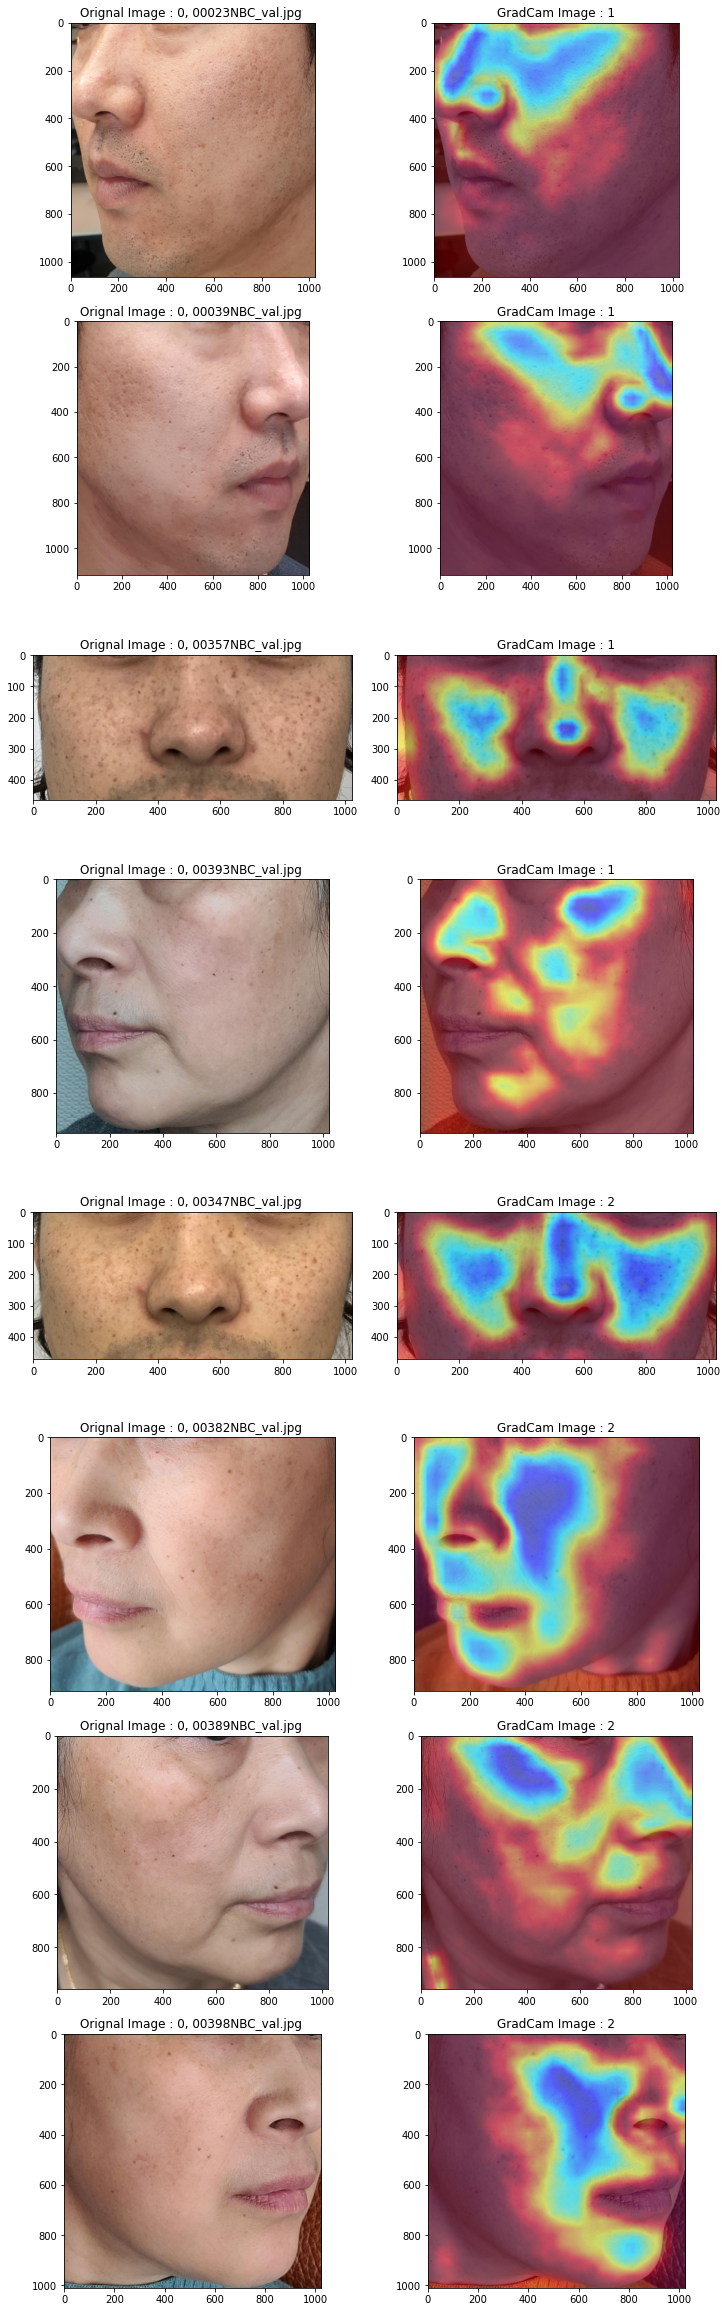

In [103]:
fig, ax = plt.subplots(nrows=len(test_data), ncols=2, figsize=(10, 4*len(test_data)), constrained_layout=True)


for row_num, (idx, img_n, gt, pred) in enumerate(test_data):
    # oil_label = all_data[row_num][1]
    # preds_label = all_data[row_num][2]
    # img_n = all_data[row_num][0]
    # if oil_label == 0 and preds_label == 0:
    # Original Image
    ax[row_num][0].imshow(images[idx])
    ax[row_num][0].set_title(f"Orignal Image : {gt}, {img_n} ")

    # Pred Mask
    # ax[row_num][1].imshow(label_to_color_image(masks[row_num]))
    ax[row_num][1].imshow(grad_cams[idx])
    ax[row_num][1].set_title(f"GradCam Image : {pred}")
    # ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# plt.show()
plt.savefig(f'gt{label}-{flag}.jpg')

In [95]:
dataset_path = '/opt/ml/data/naverboostcamp_val/JPEGImages/'
# with torch.no_grad():
#     for index, (img, oil_label, image_info) in enumerate(valLoader):
#             imgs = img
#             oil_labels = oil_label
#             image_infos = image_info
flag = False
label = 0
test_data = []
if flag:
    for idx, (img_n, gt, pred) in enumerate(all_data):
        if gt == label and gt == pred :
            test_data.append(idx, img_n, gt, pred)
else :
    for idx, (img_n, gt, pred) in enumerate(all_data):
        if gt == label and gt != pred : 
            test_data.append(idx, img_n, gt, pred)

images = []
grad_cams = []
for idx in range(len(test_data)):
    img_path = os.path.join(dataset_path,test_data[idx][0])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
for idx in range(len(test_data)):
    img_path = os.path.join(dataset_path,test_data[idx][0])
    rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    cam_algorithm = methods["gradcam"]
    with cam_algorithm(model=model,
                       target_layers=target_layers,
                       use_cuda=True) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 462
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
        grad_cams.append(cam_image)

# flag = False
# label = 0
# test_data = []
# if flag:
#     for idx, (img_n, gt, pred) in enumerate(all_data):
#         if gt == label and gt == pred :
#             test_data.append(idx, img_n, gt, pred)
# else :
#     for idx, (img_n, gt, pred) in enumerate(all_data):
#         if gt == label and gt != pred : 
#             test_data.append(idx, img_n, gt, pred)

fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 4*n), constrained_layout=True)


for (idx, img_n, gt, pred) in test_data:
    # oil_label = all_data[row_num][1]
    # preds_label = all_data[row_num][2]
    # img_n = all_data[row_num][0]
    # if oil_label == 0 and preds_label == 0:
    # Original Image
    ax[row_num][0].imshow(images[idx])
    ax[row_num][0].set_title(f"Orignal Image : {gt}, {img_n} ")

    # Pred Mask
    # ax[row_num][1].imshow(label_to_color_image(masks[row_num]))
    ax[row_num][1].imshow(grad_cams[idx])
    ax[row_num][1].set_title(f"GradCam Image : {pred}")
    # ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# plt.show()
plt.savefig(f'gt{label}-{flag}.jpg')

TypeError: append() takes exactly one argument (4 given)